In [6]:
import yaml
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np
import math

In [33]:
# Load the YAML file
results_dir = "subset_400_2023-08-21-22:19:47_uneven_bs16"
training_length = results_dir[7:11]
print(training_length)
out_dir = Path("/workspace/gfm-gap-filling-baseline/data/results")  # Replace with the actual path to your YAML file
data_file_path = out_dir / results_dir / "chip_stats.csv"
val_cloud_path = out_dir / results_dir / "validate_clouds.csv"
save_dir = out_dir / results_dir

data_table = pd.read_csv(data_file_path)
val_clouds = pd.read_csv(val_cloud_path)
val_clouds.sort_values(by='fmask_name', inplace=True)


df = pd.concat([data_table.reset_index(drop=True), val_clouds.reset_index(drop=True)], axis=1)
print(df.columns)

400_
Index(['chip_id', 'chip_x', 'chip_y', 'tile', 'valid_first', 'valid_second',
       'valid_third', 'bad_pct_first', 'bad_pct_second', 'bad_pct_third',
       'first_image_date', 'second_image_date', 'third_image_date',
       'bad_pct_max', 'na_count', 'usage', 'Overall SSIM', 'Overall MSE',
       'Overall MAE', 'Mask Ratio', 'B02 MSE', 'B03 MSE', 'B04 MSE', 'B05 MSE',
       'B07 MSE', 'B08 MSE', 'B02 MAE', 'B03 MAE', 'B04 MAE', 'B05 MAE',
       'B07 MAE', 'B08 MAE', 'B02 SSIM', 'B03 SSIM', 'B04 SSIM', 'B05 SSIM',
       'B07 SSIM', 'B08 SSIM', 'fmask_name', 'cloud_pct', 'usage', 'bin'],
      dtype='object')


In [34]:
df['first_image_date'] = pd.to_datetime(df['first_image_date'])
df['second_image_date'] = pd.to_datetime(df['second_image_date'])
df['third_image_date'] = pd.to_datetime(df['third_image_date'])


# Calculate the difference in days
df['Time Gap'] = (df['third_image_date'] - df['first_image_date']).dt.days
df['Cloud Ratio'] = df['cloud_pct']
df['Overall RMSE'] = np.sqrt(df['Overall MSE'])
df['SSIM Error'] = (1 - df['Overall SSIM']) / df['Cloud Ratio']
print(df.head())
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...  B07 SSIM  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.944236   
1      50165.0       0.047832        0.011958       0.009965  ...  0.707652   
2      50176.0       0.000000        0.001993       0.000000  ...  0.955927   
3      49757.0       0.739397        0.033881       0.197305  ...  0.788985   
4      50163.0       0.011958        0.023916       0.023916  ...  0.889901   

   B08 SSIM                fmask_name  cloud_pct     usage      bin 

In [35]:
columns_to_average = [
    'B02 MSE', 'B03 MSE', 'B04 MSE', 'B05 MSE',
    'B07 MSE', 'B08 MSE', 'B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE',
    'B02 SSIM', 'B03 SSIM', 'B04 SSIM', 'B05 SSIM',
    'B07 SSIM', 'B08 SSIM'
]
mae_list = ['B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE']
mae_averages = df[mae_list].mean()
means = [mean / 10000 for mean in [495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031]]
error = mae_averages / means
print(error)
# Calculate column averages
column_averages = df[columns_to_average].mean()

# Print the calculated averages
print(column_averages)

B02 MAE    0.359255
B03 MAE    0.265630
B04 MAE    0.402287
B05 MAE    0.203986
B07 MAE    0.215423
B08 MAE    0.329147
dtype: float64
B02 MSE     0.000623
B03 MSE     0.000929
B04 MSE     0.002702
B05 MSE     0.006198
B07 MSE     0.005928
B08 MSE     0.006362
B02 MAE     0.017809
B03 MAE     0.021626
B04 MAE     0.037194
B05 MAE     0.060432
B07 MAE     0.056891
B08 MAE     0.057281
B02 SSIM    0.921054
B03 SSIM    0.924322
B04 SSIM    0.850327
B05 SSIM    0.813494
B07 SSIM    0.855049
B08 SSIM    0.828311
dtype: float64


             Overall SSIM Overall MAE Cloud Ratio Time Gap
Overall SSIM       1.0***    -0.36***    -0.92***    -0.01
Overall MAE      -0.36***      1.0***     0.14***  0.19***
Cloud Ratio      -0.92***     0.14***      1.0***    -0.02
Time Gap            -0.01     0.19***       -0.02   1.0***
              Overall SSIM  Overall MAE  Cloud Ratio  Time Gap
Overall SSIM      1.000000    -0.356561    -0.918058 -0.009533
Overall MAE      -0.356561     1.000000     0.141301  0.188701
Cloud Ratio      -0.918058     0.141301     1.000000 -0.017933
Time Gap         -0.009533     0.188701    -0.017933  1.000000


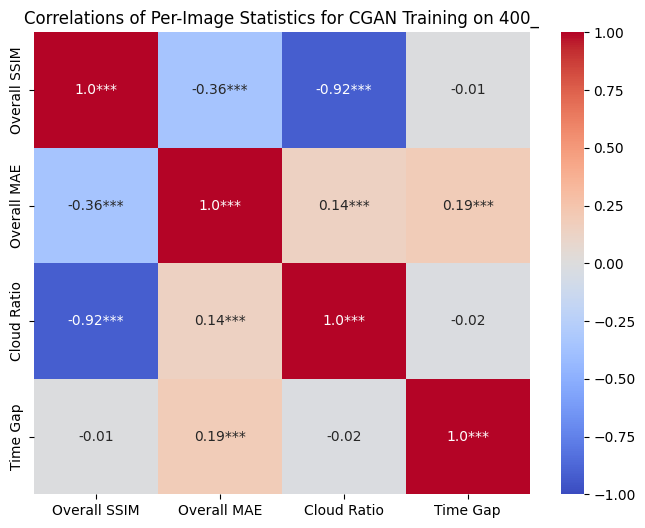

In [36]:
df = df[['Overall SSIM', 'Overall MAE',
       'Cloud Ratio', 'Time Gap']]


rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
significant_correlations = rho.round(2).astype(str) + p
print(significant_correlations)
print(rho)



# Create the heatmap of p-values
plt.figure(figsize=(8, 6))
sns.heatmap(rho, annot=significant_correlations, fmt='', cmap="coolwarm", vmin=-1, vmax=1)  # Format to 3 decimal places
plt.title(f'Correlations of Per-Image Statistics for CGAN Training on {training_length}')

plt.savefig(save_dir / 'per_image_correlations.png', format='png')

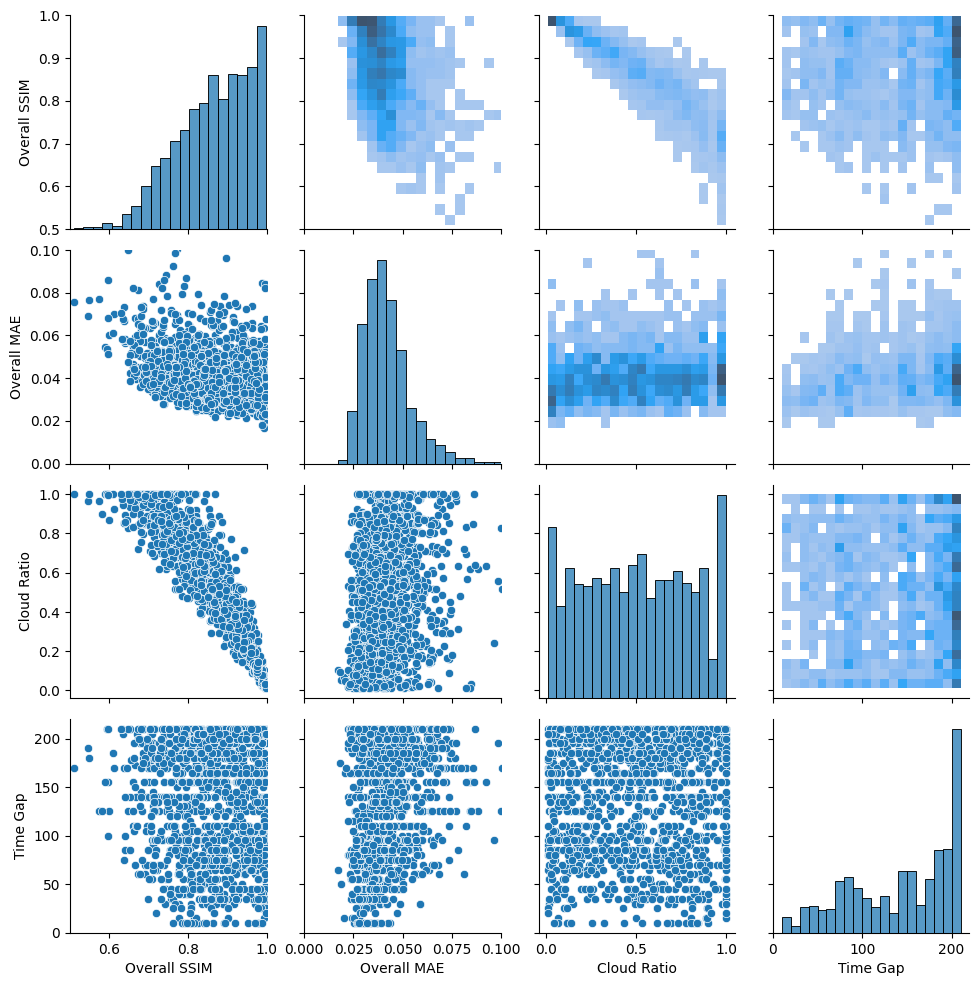

In [37]:
df = df[['Overall SSIM', 'Overall MAE', 'Cloud Ratio', 'Time Gap']]
g = sns.PairGrid(df, diag_sharey=False)

g.map_upper(sns.histplot, bins=20)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, bins=20)

g.axes[0,0].set_xlim(0.5,1)
g.axes[0,0].set_ylim(0.5,1)
g.axes[1,1].set_xlim(0,0.1)
g.axes[1,1].set_ylim(0,0.1)


plt.savefig(save_dir / 'per_image_pairgrid.png', format='png')